# CNN MODEL

## Import packages

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from google.cloud import storage
import json
import ndjson
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Download a sample class to examine data

In [164]:
! gsutil ls -r gs://quickdraw_dataset/full/numpy_bitmap/

gs://quickdraw_dataset/full/numpy_bitmap/:
gs://quickdraw_dataset/full/numpy_bitmap/The Eiffel Tower.npy
gs://quickdraw_dataset/full/numpy_bitmap/The Great Wall of China.npy
gs://quickdraw_dataset/full/numpy_bitmap/The Mona Lisa.npy
gs://quickdraw_dataset/full/numpy_bitmap/aircraft carrier.npy
gs://quickdraw_dataset/full/numpy_bitmap/airplane.npy
gs://quickdraw_dataset/full/numpy_bitmap/alarm clock.npy
gs://quickdraw_dataset/full/numpy_bitmap/ambulance.npy
gs://quickdraw_dataset/full/numpy_bitmap/angel.npy
gs://quickdraw_dataset/full/numpy_bitmap/animal migration.npy
gs://quickdraw_dataset/full/numpy_bitmap/ant.npy
gs://quickdraw_dataset/full/numpy_bitmap/anvil.npy
gs://quickdraw_dataset/full/numpy_bitmap/apple.npy
gs://quickdraw_dataset/full/numpy_bitmap/arm.npy
gs://quickdraw_dataset/full/numpy_bitmap/asparagus.npy
gs://quickdraw_dataset/full/numpy_bitmap/axe.npy
gs://quickdraw_dataset/full/numpy_bitmap/backpack.npy
gs://quickdraw_dataset/full/numpy_bitmap/banana.npy
gs://quickdraw_d

In [18]:
! gsutil cp 'gs://quickdraw_dataset/full/numpy_bitmap/The Mona Lisa.npy' './data/numpy_bitmap/The Mona Lisa.npy'

Copying gs://quickdraw_dataset/full/numpy_bitmap/The Mona Lisa.npy...
\ [1 files][ 90.8 MiB/ 90.8 MiB]                                                
Operation completed over 1 objects/90.8 MiB.                                     


In [165]:
pwd

'/home/jupyter/data'

In [12]:
# Load data into numpy array from downloaded file
data = np.load('/home/jupyter/data/numpy_bitmap/The Mona Lisa.npy')

In [29]:
data.shape

(121383, 784)

In [33]:
def draw_bitmap(array):
    # Reshape the array to 28x28
    bitmap = array.reshape(28, 28)

    # Plot the bitmap
    plt.imshow(bitmap, cmap='gray')
    plt.axis('off')  # Turn off axis
    plt.show()

def draw_bitmap_grid(data, rows, cols):
    n_rows, n_cols = rows, cols
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 10))

    for i in range(n_rows):
        for j in range(n_cols):
            index = i * n_cols + j
            bitmap = data[index].reshape(28, 28)
            axs[i, j].imshow(bitmap, cmap='gray')
            axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

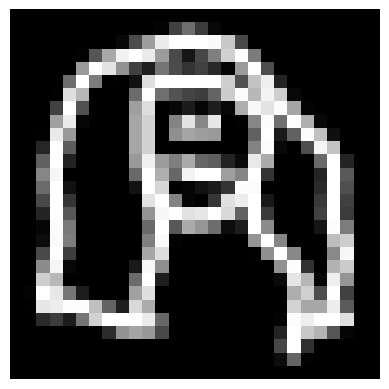

In [32]:
draw_bitmap(data[0])

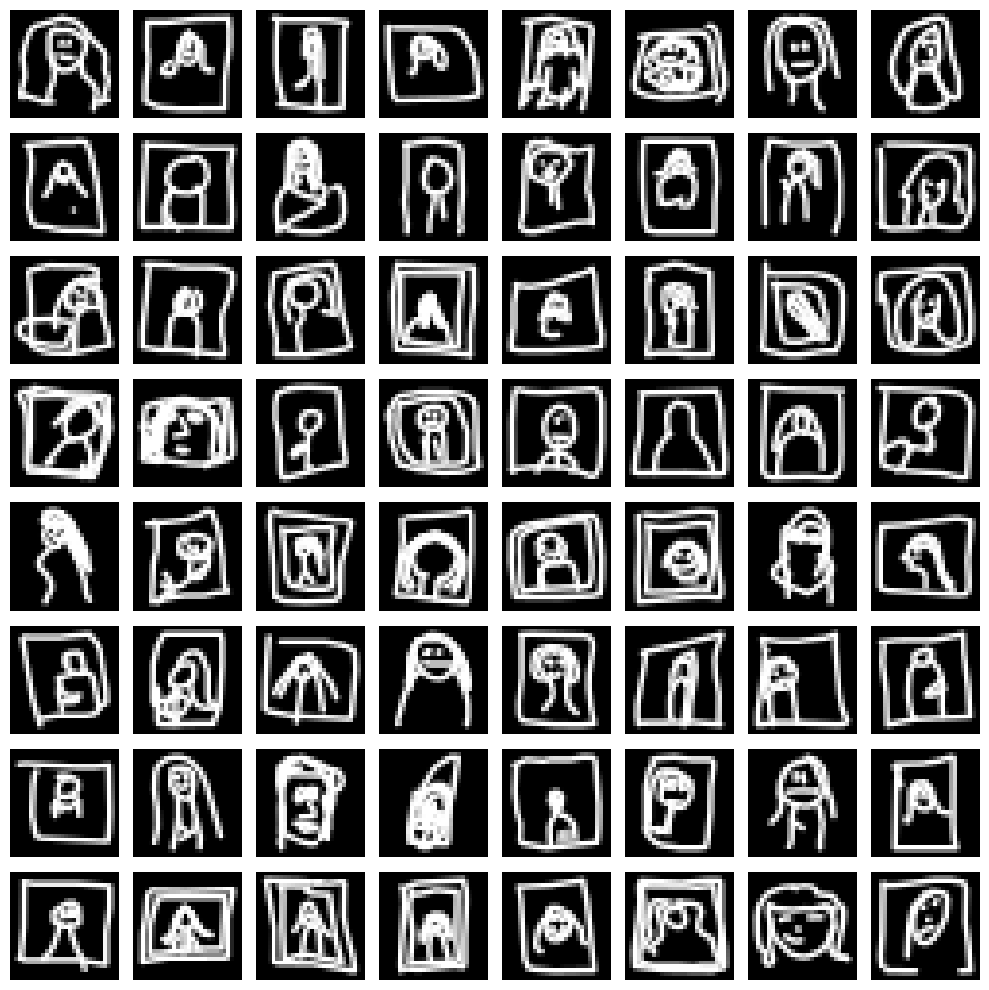

In [34]:
draw_bitmap_grid(data, 8, 8)

## Download our 50 class subset

In [13]:
with open('/home/jupyter/data/mappings/dict_50_class_subset.json','r') as f :
    dict_50_class_subset = json.load(f)

In [16]:
# dict_50_class_subset = {'aircraft carrier': 0, 'arm': 1, 'asparagus': 2, 'backpack': 3, 'banana': 4, 'basketball': 5, 'bottlecap': 6, 'bread': 7, 'broom': 8, 'bulldozer': 9, 'butterfly': 10, 'camel': 11, 'canoe': 12, 'chair': 13, 'compass': 14, 'cookie': 15, 'drums': 16, 'eyeglasses': 17, 'face': 18, 'fan': 19, 'fence': 20, 'fish': 21, 'flying saucer': 22, 'grapes': 23, 'hand': 24, 'hat': 25, 'horse': 26, 'light bulb': 27, 'lighthouse': 28, 'line': 29, 'marker': 30, 'mountain': 31, 'mouse': 32, 'parachute': 33, 'passport': 34, 'pliers': 35, 'potato': 36, 'sea turtle': 37, 'snowflake': 38, 'spider': 39, 'square': 40, 'steak': 41, 'swing set': 42, 'sword': 43, 'telephone': 44, 'television': 45, 'tooth': 46, 'traffic light': 47, 'trumpet': 48, 'violin': 49}

In [17]:
file_list = [name+'.npy' for name in list(dict_50_class_subset.keys())]
print(file_list)

['aircraft carrier.npy', 'arm.npy', 'asparagus.npy', 'backpack.npy', 'banana.npy', 'basketball.npy', 'bottlecap.npy', 'bread.npy', 'broom.npy', 'bulldozer.npy', 'butterfly.npy', 'camel.npy', 'canoe.npy', 'chair.npy', 'compass.npy', 'cookie.npy', 'drums.npy', 'eyeglasses.npy', 'face.npy', 'fan.npy', 'fence.npy', 'fish.npy', 'flying saucer.npy', 'grapes.npy', 'hand.npy', 'hat.npy', 'horse.npy', 'light bulb.npy', 'lighthouse.npy', 'line.npy', 'marker.npy', 'mountain.npy', 'mouse.npy', 'parachute.npy', 'passport.npy', 'pliers.npy', 'potato.npy', 'sea turtle.npy', 'snowflake.npy', 'spider.npy', 'square.npy', 'steak.npy', 'swing set.npy', 'sword.npy', 'telephone.npy', 'television.npy', 'tooth.npy', 'traffic light.npy', 'trumpet.npy', 'violin.npy']


In [70]:
# Download a blob from a bucket and store it in memory
def download_numpy_bitmap_to_file(bucket_name, source_blob_name, destination_path) -> None:
    '''
    Downloads a (ndjson) blob from the bucket and return json file as dict
    '''
    # Initialize a client
    storage_client = storage.Client()

    # Get the bucket
    bucket = storage_client.bucket(bucket_name)

    # Get the blob
    blob = bucket.blob(source_blob_name)

    # Download the file to local storage
    blob.download_to_filename(destination_path)

    return None

In [18]:
bucket_name = 'quickdraw_dataset'
blob_prefix = 'full/numpy_bitmap/'
local_folder_path = '/home/jupyter/data/numpy_bitmap/'

In [2]:
for file in file_list :
    source_blob_name = blob_prefix+file
    print(source_blob_name)
    destination_file_path = local_folder_path+file
    print(destination_file_path)
    download_numpy_bitmap_to_file(bucket_name, source_blob_name, destination_file_path)
    print(f'Downloaded {file}')

NameError: name 'file_list' is not defined

### Take 10% of 50 class subset
Create list of dict -> each dict is one bmp

In [19]:
# Create sample_np_bmps - a list of dictionaries
step_size = 10 # i.e. 10% sample
bmp_50class_10pc = []

# Loop through each numpy file
for i in range(len(file_list)):
    file = file_list[i]
    file_path = local_folder_path+file

    # Load .np file
    array = np.load(file_path)
    print(f'Loaded {file} with {len(array)} rows')

    # Create a list of dictionaries - stepping through sampled array (i.e step size of 10 = 10% sample)
    dict_list = [{'class':file.replace('.npy',''),'bmp':bmp} for bmp in array[::step_size]]
    print(f'Adding {len(dict_list)} rows')

    bmp_50class_10pc = bmp_50class_10pc + dict_list

Loaded aircraft carrier.npy with 116504 rows
Adding 11651 rows
Loaded arm.npy with 120951 rows
Adding 12096 rows
Loaded asparagus.npy with 168102 rows
Adding 16811 rows
Loaded backpack.npy with 125801 rows
Adding 12581 rows
Loaded banana.npy with 307936 rows
Adding 30794 rows
Loaded basketball.npy with 133793 rows
Adding 13380 rows
Loaded bottlecap.npy with 153207 rows
Adding 15321 rows
Loaded bread.npy with 120570 rows
Adding 12057 rows
Loaded broom.npy with 116927 rows
Adding 11693 rows
Loaded bulldozer.npy with 187409 rows
Adding 18741 rows
Loaded butterfly.npy with 117999 rows
Adding 11800 rows
Loaded camel.npy with 121399 rows
Adding 12140 rows
Loaded canoe.npy with 123767 rows
Adding 12377 rows
Loaded chair.npy with 222706 rows
Adding 22271 rows
Loaded compass.npy with 127609 rows
Adding 12761 rows
Loaded cookie.npy with 131353 rows
Adding 13136 rows
Loaded drums.npy with 137299 rows
Adding 13730 rows
Loaded eyeglasses.npy with 225762 rows
Adding 22577 rows
Loaded face.npy with 1

In [20]:
print(len(bmp_50class_10pc))
print(bmp_50class_10pc[0])

797637
{'class': 'aircraft carrier', 'bmp': array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0

In [146]:
# # Save bmp sample list to folder
# def save_json_to_local (data: list, folder_path: str, file_name: str) -> None:
#     file_path = folder_path+file_name
#     with open(file_path, 'w') as file :
#         json.dump(data, file)
#     print(f'Saved data to {file_path}')
#     return None

# bmp_50class_10pc_tolist = bmp_50class_10pc.copy()
# for bmp in bmp_50class_10pc_tolist :
#     bmp['bmp'] = bmp['bmp'].tolist()

# save_json_to_local(bmp_50class_10pc_tolist, local_folder_path, 'bmp_50class_10pc_tolist.json')

## Prepare dataset for model
* Normalised X - i.e. convert values from [0,255] to [0,1]
* OHC Y manually using mapping dictionary
* Shuffle list

In [21]:
def OHE_class_name(class_name: str, mapping_dict: dict) -> list:
    nb_classes = len(mapping_dict)
    OHE_output = [0] * nb_classes
    OHE_output[mapping_dict[class_name]] = 1
    # Need to convert the np.ndarray into a list so it can be parsed into JSON
    return OHE_output

In [22]:
for i in range(len(bmp_50class_10pc)) :
    drawing = bmp_50class_10pc[i]

    # Normalise X value - i.e. divide by 255
    drawing['bmp'] = drawing['bmp']/255
    # Reshape X in 28x28 bmp shape
    drawing['bmp'] = drawing['bmp'].reshape(28,28)
    # OHE class
    drawing['OHE_class'] = OHE_class_name(drawing['class'], dict_50_class_subset)


In [23]:
bmp_50class_10pc[0]

{'class': 'aircraft carrier',
 'bmp': array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        

In [24]:
# Shuffle list
random.shuffle(bmp_50class_10pc)

In [25]:
# Check the data has been suitably shuffled
print([drawing['class'] for drawing in bmp_50class_10pc[0:50]])

['snowflake', 'traffic light', 'hand', 'bulldozer', 'hand', 'bulldozer', 'butterfly', 'fan', 'fish', 'bottlecap', 'hand', 'fence', 'spider', 'grapes', 'chair', 'lighthouse', 'marker', 'line', 'spider', 'chair', 'horse', 'pliers', 'fence', 'chair', 'trumpet', 'swing set', 'marker', 'television', 'hat', 'bottlecap', 'broom', 'chair', 'lighthouse', 'marker', 'drums', 'trumpet', 'trumpet', 'parachute', 'grapes', 'telephone', 'asparagus', 'bottlecap', 'marker', 'banana', 'violin', 'passport', 'bread', 'hat', 'line', 'butterfly']


# RUN A CNN MODEL ON DATASET

## Prepare train, val and test sets for model

In [27]:
# Import relevant packages:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
from typing import Tuple
import time

In [28]:
X = np.array([drawing['bmp'] for drawing in bmp_50class_10pc])
X.shape

(797637, 28, 28)

In [29]:
y = np.array([drawing['OHE_class'] for drawing in bmp_50class_10pc])
y.shape

(797637, 50)

In [30]:
# Split X_train & y_train in train and val sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [31]:
print(len(X_train))
print(len(X_test))

558345
239292


## Initialise & compile model

In [32]:
# Initialise model
def initialize_model() -> models.Model:
    '''
    Initialise model with the same CNN structure we used for number recognition - accepting bmp files of dimension 28x28 bits
    * `Conv2D` layer with 8 filters, each of size (4, 4), an input shape of (28x28), the `relu` activation function, and `padding='same'
    * `MaxPool2D` layer with a `pool_size` equal to (2, 2)
    * second `Conv2D` layer with 16 filters, each of size (3, 3), and the `relu` activation function
    * second `MaxPool2D` layer with a `pool_size` equal to (2, 2)

    * `Flatten` layer
    * first `Dense` layer with 10 neurons and the `relu` activation function
    * last softmax predictive layer of 50 classes - i.e. number of classes in data subset
    '''

    model = models.Sequential()

    ### First Convolution & MaxPooling
    model.add(layers.Conv2D(8, (4,4), input_shape=(28, 28, 1), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### Second Convolution & MaxPooling
    model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### Flattening
    model.add(layers.Flatten())

    ### One Fully Connected layer - "Fully Connected" is equivalent to saying "Dense"
    model.add(layers.Dense(10, activation='relu'))

    ### Last layer - Classification Layer with 10 outputs corresponding to 10 digits
    model.add(layers.Dense(50, activation='softmax'))

    print("✅ Model initialized")

    return model

In [33]:
def compile_model(model: models.Model, learning_rate=0.0005) -> models.Model:
    '''
    Compile the model, which:
    * optimizes the `categorical_crossentropy` loss function,
    * with the `adam` optimizer with learning_rate=0.0005,
    * and the `accuracy` as the metrics
    '''

    # Create optimizer with custom learning rate
    optimizer = Adam(learning_rate=learning_rate)

    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])

    print("✅ Model compiled")

    return model

## Train model

In [34]:
# Save json to local folder - to store training history
def save_json_to_local (data: list, folder_path: str, file_name: str) -> None:
    file_path = folder_path+file_name
    with open(file_path, 'w') as file :
        json.dump(data, file)
    print(f'Saved data to {file_path}')
    return None

In [ ]:
def train_model(
            model: models.Model,
            X: np.ndarray,
            y: np.ndarray,
            batch_size=256,
            patience=5,
            validation_data=None, # overrides validation_split, if available
            validation_split=0.2
            ) -> Tuple[models.Model, dict]:
    '''
    Train on the model and return a tuple (fitted_model, history)
    Checkpoints have also been included to store model weights after each epoch
    '''

    es = callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=patience,
            restore_best_weights=True,
            verbose=1
            )

    # Create checkpoints - add timestamp to prevent writing over old training runs
    timestr = time.strftime("%Y%m%d-%H%M%S")
    checkpoint_filepath = '/home/jupyter/data/numpy_bitmap/CNN_model'+timestr

    #Save the checkpoints in the checkpoint_filepath
    model_checkpoint_callback = callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True
            )

    history = model.fit(
            X,
            y,
            validation_data=validation_data,
            validation_split=validation_split,
            epochs=1000,
            batch_size=batch_size,
            callbacks=[es, model_checkpoint_callback],
            verbose=1
            )

    print(f"✅ Model trained on {len(X)} rows with maximum val accuracy: {round(np.min(history.history['accuracy']), 2)}")

    save_json_to_local (history, checkpoint_filepath, 'model_history_'+timestr)

    return model, history


In [58]:
def evaluate_model(
            model: models.Model,
            X: np.ndarray,
            y: np.ndarray,
            batch_size=64
            ) -> Tuple[models.Model, dict]:
    '''
    Evaluate performance of the trained model on the test dataset
    Returns evaluation metrics
    '''

    if model is None:
        print(f"\n❌ No model to evaluate")
        return None

    metrics = model.evaluate(
            x=X,
            y=y,
            batch_size=batch_size,
            verbose=1,
            # callbacks=None,
            return_dict=True
            )

    loss = metrics["loss"]
    accuracy = metrics["accuracy"]

    print(f"✅ Model evaluated, accuracy: {round(accuracy, 2)}")

    return metrics


## Run the model!

In [56]:
# Model summary
model = initialize_model()
model = compile_model(model)
model.summary()

✅ Model initialized
✅ Model compiled
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 8)         136       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 16)        1168      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 7, 7, 16)         0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_10 (Dense)

In [ ]:
model, history = train_model(model, X_train, y_train, validation_split=0.2)

Epoch 1/1000
1745/1745 [==============================] - 22s 12ms/step - loss: 2.4684 - accuracy: 0.3729 - val_loss: 1.9501 - val_accuracy: 0.5086
Epoch 2/1000
1745/1745 [==============================] - 21s 12ms/step - loss: 1.8132 - accuracy: 0.5399 - val_loss: 1.7121 - val_accuracy: 0.5642
Epoch 3/1000
1745/1745 [==============================] - 21s 12ms/step - loss: 1.6519 - accuracy: 0.5812 - val_loss: 1.6004 - val_accuracy: 0.5975
Epoch 4/1000
1745/1745 [==============================] - 21s 12ms/step - loss: 1.5719 - accuracy: 0.6022 - val_loss: 1.5483 - val_accuracy: 0.6076
Epoch 5/1000
1745/1745 [==============================] - 21s 12ms/step - loss: 1.5230 - accuracy: 0.6159 - val_loss: 1.5128 - val_accuracy: 0.6230
Epoch 6/1000
1745/1745 [==============================] - 21s 12ms/step - loss: 1.4878 - accuracy: 0.6257 - val_loss: 1.4831 - val_accuracy: 0.6264
Epoch 7/1000
1745/1745 [==============================] - 21s 12ms/step - loss: 1.4615 - accuracy: 0.6329 - val_

In [55]:
evaluate_model(model, X_test, y_test)

3739/3739 [==============================] - 9s 2ms/step - loss: 3.9180 - accuracy: 0.0212
✅ Model evaluated, accuracy: 0.02


{'loss': 3.9179511070251465, 'accuracy': 0.021191682666540146}